<a href="https://colab.research.google.com/github/Jonathanace/Traveling-Salesman-Project/blob/main/traveling_salesman_problem_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

- Turn Hash map into defaultdict of dictionaries to decrease lookup time.

# Implementation of [this video](https://www.youtube.com/watch?v=GiDsjIBOVoA&t=489s).

# Imports

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate Data

1. Coordinates have an x and y value, between 0 and 100.
2. The number of coordinates in the dataset is equal to "num_destinations".

In [ ]:
num_destinations = 45 # set number of destinations

,X,Y
0,77.787232,15.615083
1,41.279034,68.880283
2,6.941181,55.754557
3,57.743958,62.573228
4,48.291919,39.475446


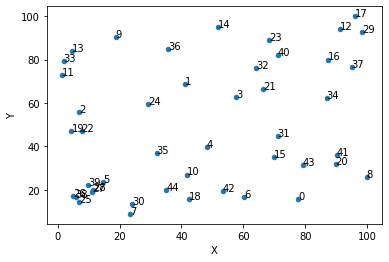

In [ ]:
# generate data
data = pd.DataFrame(np.random.random_sample(size=(num_destinations, 2)) * 100, columns=['X', 'Y']) 

# visualize data in scatterplot
fig, ax = plt.subplots()
data.plot('X', 'Y', kind='scatter', ax=ax)
for k, v in data.iterrows():
    ax.annotate(k, v)

# show table of data 
data.head()

In [ ]:
data.head

# Estimate Lower Bound by finding the 1-Tree Lower Bound
1. Find the minimum spanning tree using [Prim's Algorithm](https://en.wikipedia.org/wiki/Prim%27s_algorithm).
2. Choose a random vertex in the MST. Delete all edges connected to that vertex, and add edges connecting that vertex to the two closest vertices. This creates a 1-tree. This 1-tree is a guaranteed lower bounnd on the TSP.
3. Repeat this process for every vertex. Find the maximum-distance 1-tree that can be generated this way. This is the best (maximal) lower bound we can calculate for the TSP using this method. 

*Note: On average, the optimal TSP solution's distance will be approximately 1.25 times the 1-tree lower bound.*

Todo:
* So far only MST Lower bound has been found. Need to implement 1-tree lower bound. If possible, do so without re-calculating the MST for every missing vertex. Maybe could recalculate MST for vertices with degree > 1, and use the simple, greedy solution with degree < 1?

# Find MST using Prim's Algorithm

Todo:
* Store vertex data to later calculate 1-tree after MST is found.

In [ ]:
# imports
from collections import defaultdict
from math import sqrt

# Construct a dictionary containing distances from each vertex to each other vertex
d = defaultdict(list) # dictionary containing distances // change this to (M, T)
prevs = set() # set containing all previously visited vertices
for index, coordinate in data.iterrows(): # iterate through all vertices
  x, y = coordinate[0], coordinate[1] 
  for prev_index, prev_x, prev_y in prevs: # find distance from current vertex to all previously visited vertices
    distance = sqrt(abs(x-prev_x)**2 + abs(y-prev_y)**2) # calculate euclidian distance

    # store distance data
    d[prev_index].append((index, distance))
    d[index].append((prev_index, distance))
    d[(prev_index, index)].append(distance)
    d[(index, prev_index)].append(distance)

  prevs.add((index, x, y)) # add current vertex to set of previously visited vertices
print('Done!')

Done!


In [ ]:
# Greedily find the minimum spanning tree using Prim's Algorithm
visited = {0} # stores all previously visited vertices
unvisited = set([i for i in range(num_destinations)]) - visited # stores all unvisited vertices
odd_nodes = set() # stores all nodes with odd degree
total_distance = 0 # stores the total distance in the MST
edges = []

while unvisited:
  min_distance = float('inf')
  starting_location = next_destination = None

  # find lowest weight next destination from starting destination within set of previously visited vertices
  for start_vertex in visited:
    for end_vertex, distance in d[start_vertex]:
      if end_vertex in unvisited and distance < min_distance:
        min_distance = distance
        next_destination = end_vertex
        starting_location = start_vertex

  # update visited set, unvisited set, and total distance
  total_distance += min_distance
  unvisited.remove(next_destination)
  visited.add(next_destination)
  edges.append(sorted((starting_location, next_destination)))

  # update odd vertex set
  for location in starting_location, next_destination:
    if location in odd_nodes:
      odd_nodes.remove(location)
    elif location not in odd_nodes:
      odd_nodes.add(location)

print(total_distance, edges, odd_nodes)

465.40656527809546 [[0, 43], [15, 43], [15, 31], [20, 43], [20, 41], [8, 20], [0, 6], [6, 42], [18, 42], [18, 44], [10, 44], [30, 44], [7, 30], [5, 30], [5, 28], [27, 28], [28, 39], [27, 38], [26, 38], [25, 38], [10, 35], [4, 10], [21, 31], [3, 21], [21, 32], [32, 40], [23, 40], [16, 40], [16, 37], [12, 16], [12, 29], [17, 29], [34, 37], [1, 3], [1, 24], [1, 36], [14, 23], [9, 36], [9, 13], [13, 33], [11, 33], [2, 11], [2, 22], [19, 22]] {1, 4, 7, 8, 10, 14, 16, 17, 19, 20, 21, 24, 25, 26, 28, 30, 34, 35, 38, 39, 40, 41, 43, 44}


# Find 1-Tree Lower Bound (Todo)


# Generate Optimal TSP Using Christofides Algorithm

In [ ]:
# define function to generate all perfect pair matchings for odd degree nodes
def find_pairs(l):
  if len(l) < 2:
    yield []
    return

  a = l[0]
  for i in range(1, len(l)):
    pair = (a, l[i])
    for rest in find_pairs(l[1:i]+l[i+1:]):
      yield [pair] + rest

In [ ]:
# generate pairs for odd degree nodes:
perfect_matching_span = float('inf')
perfect_matching = None
for matching in find_pairs(list(odd_nodes)):
  matching_span = sum([d[pair][0] for pair in matching])
  if matching_span < perfect_matching_span:
    perfect_matching_span = matching_span
    perfect_matching = matching

# Generate Eulerian Tour Using Hierholzer's Algorithm

In [ ]:
# Hierholzer's algorithm
eulerian_tour = []

final_nodes = defaultdict(list)

unvisited_nodes = set([i for i in range(num_destinations)])
for edge in edges + perfect_matching:
  # print(edge)
  n1, n2 = edge
  final_nodes[n1].append(n2)
  final_nodes[n2].append(n1)
'''
print()

for node in final_nodes.keys():
  print(node, final_nodes[node])
'''

cur_node = 0

# generate initial tour
while final_nodes[cur_node]:
  eulerian_tour.append(cur_node) # add cur node to final tour
  # visited_nodes.add(cur_node) # add cur node to visited nodes 
  if cur_node in unvisited_nodes:
    unvisited_nodes.remove(cur_node)

  # update cur node
  prev_node = cur_node
  cur_node = final_nodes[cur_node].pop(0)
  final_nodes[cur_node].remove(prev_node)
  # print(prev_node, cur_node)


for node in final_nodes.keys():
  print(node, final_nodes[node])
print(eulerian_tour, unvisited_nodes)


# create sub-tours to add all unvisited nodes to main tour
while unvisited_nodes:
  
  # rotate eulerian tour until "end" node includes an edge to an unvisited node
  while not final_nodes[eulerian_tour[-1]]:
    eulerian_tour.insert(0, eulerian_tour.pop(-1))

  # Generate a tour, starting from that node, visiting random edges, until the tour ends back at the starting node. Add this tour to the final tour.
  prev_node = eulerian_tour[-1]
  cur_node = final_nodes[prev_node].pop()
  final_nodes[cur_node].remove(prev_node)

  while final_nodes[cur_node]:
    eulerian_tour.append(cur_node)
    if cur_node in unvisited_nodes:
      unvisited_nodes.remove(cur_node)
    prev_node = cur_node
    cur_node = final_nodes[cur_node].pop(0)
    final_nodes[cur_node].remove(prev_node)


print()
for node in final_nodes.keys():
  print(node, final_nodes[node])
print(eulerian_tour, unvisited_nodes)

final_tour_length = 0
final_tour = [eulerian_tour[0]]
prev_nodes = {eulerian_tour[0]}
for i in range(1, len(eulerian_tour)):
  node = eulerian_tour[i]
  if node not in prev_nodes:
    final_tour.append(node)
    prev_nodes.add(node)
    final_tour_length += d[(node, eulerian_tour[i-1])][0]

print(final_tour)

In [ ]:
print(f'MST lower bound: {total_distance}')
print(f'final tour length: {final_tour_length}')

In [ ]:
raise Exception("All current code finished executing")

# OLD CODE


In [ ]:
# for each vertex, create a minimum spanning tree excluding that vertex. Then, connect the two shortest verteices from the excluded vertex to that vertex. Record the total distance of the resulting 1-tree. 
walks = []
# first pass, exclude vertex 0, start at vertex 1
total_distance = 0
excluded_vertex = 0
visited = {1}
unvisited_set = set(list(d.keys()))
unvisited = unvisited_set - visited - {excluded_vertex}
next_destination = None
while unvisited:
  min_distance = float('inf')
  for vertex in visited:
    for destination, distance in d[vertex]:
      if destination in unvisited and destination != excluded_vertex and distance < min_distance:
        min_distance = distance
        next_destination = destination
  total_distance += min_distance
  unvisited.remove(next_destination)
  visited.add(next_destination)
total_distance += sum(sorted([i[1] for i in d[1]])[:2])
max_distance = total_distance
print(total_distance)
print('Done!')
walks.append(total_distance)

In [ ]:
# make a set of odd vertices. If a vertex is used and it isn't in the set, add it to the set. Otherwise, if it's already in the set, remove it from the set. 

In [ ]:
# repeat above for the rest of the vertices, always using 0 as the starting point for the 1-tree. 
for excluded_vertex in range(1, num_destinations):
  total_distance = 0
  visited = {0}
  unvisited = unvisited_set - visited - {excluded_vertex}
  next_destination = None
  while unvisited:
    min_distance = float('inf')
    for vertex in visited:
      for destination, distance in d[vertex]:
        if destination in unvisited and destination != excluded_vertex and distance < min_distance:
          min_distance = distance
          next_destination = destination
    total_distance += min_distance
    unvisited.remove(next_destination)
    visited.add(next_destination)
  total_distance += sum(sorted([i[1] for i in d[0]])[:2])
  max_distance = max(max_distance, total_distance)
  walks.append(total_distance)
  print(f'Distance for walk excluding vertex {excluded_vertex}: {total_distance}. Max distance: {max_distance}.')
print('Done!')
print(walks)

In [ ]:
print(f'{max_distance} is an absolute lower bound for the TSP. The best TSP will be roughly 1.25x that value, which in this case is {max_distance * 1.25}')

Since there is a unique MST, we can just go through each node of that MST to find the 1-tree for that node instead of calculating the MST each time. 

Overall Steps:
1. Hash the distance from each node to each other node.
2. Use Prim's Algorithm to store the minimum spanning tree. Store this tree for later. 
3. For each node in the MST, find the minimum weight 1-tree starting from that node. The maximum of these 1-trees is a lower bound for the optimal TSP. 
4. Take the MST, then use Christofides Algorithm to find a suitably optimal TSP solution. 
  1. Find MST of graph T using **Prim's Algorithm**
  **Christofedes Algorithm**
  2. Isolate set of odd vertices S
  3. Find min weight perfect matching M of S using **FKT Algorithm** (maybe blossom algorithm)
  4. Combine T and M into multigraph G
  5. Find **Eulerian tour** of G
  6. Generate TSP from Eulerian tour



# Sources 
- https://medium.com/@yusufaksoyeng/finding-the-eulerian-cycle-with-hierholzers-algorithm-f60bb773db3c
